In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import copy
from matplotlib import colors
from sklearn import tree
#import skfda
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import timeshap
from timeshap.explainer import event_level, feature_level

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import scipy.signal
#import cartopy.crs as ccrs
#import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
#import torch.nn.functional as F
#from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  

In [ ]:
def train_test_ds_by_year(x_train, y_train, test_years = [2015, 2016, 2017], year_column = -2, train_proportion = 0.8):
    samples_in_test_years = torch.isin(x_train[:, year_column, 0], torch.Tensor(test_years))
    train_ds = TensorDataset(x_train[~samples_in_test_years, :, :], y_train[~samples_in_test_years, :])
    val_ds = TensorDataset(x_train[samples_in_test_years, :, :], y_train[samples_in_test_years, :])
    return train_ds, val_ds

def train_test_dl_by_year(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.8, test_years = [2015, 2016, 2017], year_column = -2):
    train_ds, val_ds = train_test_ds_by_year(x_train, y_train, train_proportion = train_proportion, test_years = test_years, year_column = year_column)
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

In [ ]:
def feats_to_dayofseason(df):
    df['Feature'] = 163 - df['Feature'].str.extract(r'(\d+\.\d+|\d+)').astype(int)
    return df

In [ ]:
def run_for_timeshap(x1s, TS_model, CNN=True, MMD=False, DTF=False, observed=None, bce=True):
    list_logs = []
    list_observed = []
    xb = torch.Tensor(x1s)
    with torch.no_grad():
        if CNN:
            if MMD:
                list_logs = TS_model(xb)[0]
            else:
                list_logs = TS_model(xb)
        else:
            list_logs = TS_model(xb.transpose(1, 2))
        #print(TS_model(xb.transpose(1, 2)))
    logs = torch.squeeze(list_logs, dim=1)
    #print(logs)
    if not(DTF):
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        fitted_days = mindex_at_0(logs)
        fitted_days = 90 + logs[:, 90]
        print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
    return fitted_days.numpy()

In [ ]:
def run_for_timeshap_wrapper(xb):
    return run_for_timeshap(xb.swapaxes(1, 2), trained_model)
#run_for_timeshap_wrapper(input_xb[[0], :, :])
def run_for_timeshap_GDD_wrapper(xb):
    xb = xb.cumsum(axis=1)#xb = response(xb).cumsum(axis=1)
    yb = np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        yb[i] = np.digitize(20, xb[i, :, 0])
    return yb

In [ ]:
def feats_to_dayofseason(df):
    df['Feature'] = 163 - df['Feature'].str.extract(r'(\d+\.\d+|\d+)').astype(int)
    return df

In [ ]:
disc_list = []
disc_list_GDD = []
for ind in range(1000):
    disc_list.append(run_for_timeshap_wrapper(torch.Tensor(input_xb[ind, :, :]).unsqueeze(0)) - run_for_timeshap_wrapper(torch.Tensor(background).unsqueeze(0)))
    disc_list_GDD.append(run_for_timeshap_GDD_wrapper(torch.Tensor(input_xb_GDD[ind, :]).unsqueeze(0)) - run_for_timeshap_GDD_wrapper(torch.Tensor(background_GDD).unsqueeze(0)))


In [ ]:
stepsize = 0.25
x = [0.587931, 9.3, 28.3, 39.2, 8, 3]
x_1 = [0.684018, 9.3, 28.3, 39.2]
x_1 = [0.350398, 8.08219, 23.279068, 36.99975]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, stepsize), x[4], x[5])#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/stepsize, decimals = 0)).astype(int)]*(meantemp > 0)
def response(meantemp):
    return x_1[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x_1[1], x_1[2], x_1[3])

In [ ]:
temp_indexing = temp_NDVI_series_DE[:, [0], :]#.shape
random_indices = np.random.choice(temp_NDVI_series_DE.shape[0], 1000)
input_xb_GDD = temp_indexing.numpy()[random_indices, :, :].swapaxes(1, 2)
input_xb_GDD = response(input_xb_GDD)
#input_xb = temp_NDVI_series_DE.numpy()[random_indices, :4, :].swapaxes(1, 2)
#background_GDD = temp_NDVI_series_DE.mean(dim=0).numpy()[[0], :].swapaxes(0, 1)
background_GDD = input_xb_GDD.mean(axis=0)

In [ ]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32 #8 for SSA, 32 for DE
num_layers = 3 #2 for SSA
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_KG_DE_pre_2022_small'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'
save_name = 'CCNN_KG_DE_pre_2022_RMSE_loss' 
save_name = 'CCNN_KG_DE_pre_2022_RMSE_loss' 
#save_name = 'KFold1'

bce = True
CNN = True
MMD = False
regression=False
KG=False#True if not doing response adjustment (!!!!!)
KG_vpd = False
normalise_at_end = False
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = KG, MMD=MMD, regression=regression, KG_vpd=KG_vpd, normalise_at_end=normalise_at_end)#, target_features=temp_NDVI_series_SSA)
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'
trained_model = load_model(save_name, model)
#background = temp_NDVI_series_DE.mean(dim=0).numpy()[:4, :].swapaxes(0, 1)
#background_GDD = temp_NDVI_series_DE.mean(dim=0).numpy()[[0], :].swapaxes(0, 1)
#background=np.zeros(background.shape)
input_xb = temp_NDVI_series_DE.numpy()[random_indices, :4, :].swapaxes(1, 2)
#input_xb = temp_NDVI_series_SSA.numpy()[:, :4, :].swapaxes(1, 2)
T_min = 9 + 10*(torch.tanh(trained_model.u1.data).numpy()[0]) - 4 #normally multiplier = 2
T_opt = 28 + 7*(torch.tanh(trained_model.u2.data).numpy()[0]) - 4 #normally multiplier = 3
T_max = 39 + 3.5*torch.tanh(trained_model.u3.data).numpy()[0] - 2 #normally no multiplier
alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
beta = 1
x = input_xb
x[:, :, 0] = trained_model.u0.data.numpy()[0] * (x[:, :, 0] <= T_max) * ( ((2*((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha))*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha))
#x[:, :, 0] = response(x[:, :, 0])
#x[:, :, 0] = response(x[:, :, 0])
input_xb = x
background = input_xb.mean(axis=0)

In [ ]:
def run_for_timeshap_wrapper(xb):
    return run_for_timeshap(xb.swapaxes(1, 2), trained_model)
for event_number in range(1000):
    if event_number % 10 == 0:
        print('Processing event ', event_number)
    df = event_level(run_for_timeshap_GDD_wrapper,
                    input_xb_GDD[[event_number], :, :],
                    background_GDD,
                    0,
                    3,
                    nsamples=3200,
                    )
    df['Sample number'] = event_number
    if event_number == 0:
        all_df_GDD = df
    else:
        all_df_GDD = pd.concat([all_df_GDD, df], axis = 0)

Processing event  0
Processing event  10
Processing event  20
Processing event  30
Processing event  40
Processing event  50
Processing event  60
Processing event  70
Processing event  80
Processing event  90
Processing event  100
Processing event  110
Processing event  120
Processing event  130
Processing event  140
Processing event  150
Processing event  160
Processing event  170
Processing event  180
Processing event  190
Processing event  200
Processing event  210
Processing event  220
Processing event  230
Processing event  240
Processing event  250
Processing event  260
Processing event  270
Processing event  280
Processing event  290
Processing event  300
Processing event  310
Processing event  320
Processing event  330
Processing event  340
Processing event  350
Processing event  360
Processing event  370
Processing event  380
Processing event  390
Processing event  400
Processing event  410
Processing event  420
Processing event  430
Processing event  440
Processing event  450

In [ ]:
for event_number in range(1000):
    if event_number % 10 == 0:
        print('Processing event ', event_number)
    df = feature_level(run_for_timeshap_wrapper,
                    input_xb[[event_number], :, :],
                    background,
                    0,
                    3,
                    nsamples=3200,
                    )
    df['Sample number'] = event_number
    if event_number == 0:
        all_df_features = df
    else:
        all_df_features = pd.concat([all_df_features, df], axis = 0)

Processing event  0
Processing event  10
Processing event  20
Processing event  30
Processing event  40
Processing event  50
Processing event  60
Processing event  70
Processing event  80
Processing event  90
Processing event  100
Processing event  110
Processing event  120
Processing event  130
Processing event  140
Processing event  150
Processing event  160
Processing event  170
Processing event  180
Processing event  190
Processing event  200
Processing event  210
Processing event  220
Processing event  230
Processing event  240
Processing event  250
Processing event  260
Processing event  270
Processing event  280
Processing event  290
Processing event  300
Processing event  310
Processing event  320
Processing event  330
Processing event  340
Processing event  350
Processing event  360
Processing event  370
Processing event  380
Processing event  390
Processing event  400
Processing event  410
Processing event  420
Processing event  430
Processing event  440
Processing event  450

In [ ]:
def run_for_timeshap_wrapper(xb):
    return run_for_timeshap(xb.swapaxes(1, 2), trained_model)
for event_number in range(1000):
    if event_number % 10 == 0:
        print('Processing event ', event_number)
    df = event_level(run_for_timeshap_wrapper,
                    input_xb[[event_number], :, :],
                    background,
                    0,
                    3,
                    nsamples=3200,
                    )
    df['Sample number'] = event_number
    if event_number == 0:
        all_df_CCNN = df
    else:
        all_df_CCNN = pd.concat([all_df_CCNN, df], axis = 0)
#local_report(lambda xb: run_for_timeshap(xb.swapaxes(1, 2), trained_model), 
#                                input_xb[[0], :, :], pruning_dict, event_dict, feature_dict, cell_dict, baseline=background)

Processing event  0
Processing event  10
Processing event  20
Processing event  30
Processing event  40
Processing event  50
Processing event  60
Processing event  70
Processing event  80
Processing event  90
Processing event  100
Processing event  110
Processing event  120
Processing event  130
Processing event  140
Processing event  150
Processing event  160
Processing event  170
Processing event  180
Processing event  190
Processing event  200
Processing event  210
Processing event  220
Processing event  230
Processing event  240
Processing event  250
Processing event  260
Processing event  270
Processing event  280
Processing event  290
Processing event  300
Processing event  310
Processing event  320
Processing event  330
Processing event  340
Processing event  350
Processing event  360
Processing event  370
Processing event  380
Processing event  390
Processing event  400
Processing event  410
Processing event  420
Processing event  430
Processing event  440
Processing event  450

In [ ]:
#temp_indexing = temp_NDVI_series_DE[:, [0], :]#.shape
#input_xb_GDD = temp_indexing.numpy()[np.random.choice(temp_NDVI_series_DE.shape[0], 1000), :, :].swapaxes(1, 2)
#def run_for_timeshap_GDD_wrapper(xb):
#    df = pd.DataFrame()
#    df[[f't2m at day {n}' for n in range(163)]] = xb.swapaxes(1, 2).squeeze(axis=1)
#    df['year'] = range(len(df))
#    df['Stations_id'] = 0
#    cf = run_GDD([0.587931, 9.3, 28.3, 39.2, 8, 3], df, 't2m', response_type='Convolved_vary_spread',#_early
#        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=163,
#        thresholds = [20], title_extra='Early varieties', method = 'regression', plot=False)
#    return cf['modelled time to beginning of flowering'].values

In [ ]:
#import shap
#explainer = shap.KernelExplainer(lambda xb: run_for_timeshap(xb.swapaxes(1, 2), trained_model),
#                                 temp_NDVI_series_DE[:1000, :4, :].swapaxes(1, 2).numpy())
#shap_values = explainer.shap_values(input_xb[0,:, :])
#shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])

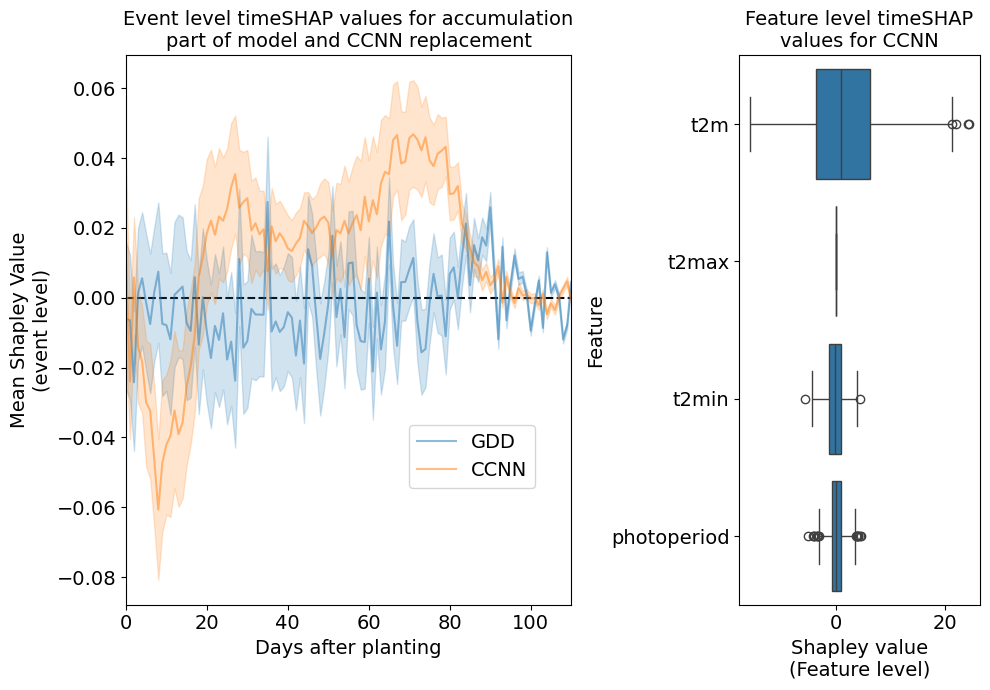

In [ ]:
font_size = 14
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(10)#22
axs = []
axs.append(plt.subplot2grid(shape=(3, 5), loc=(0, 0), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(3, 5), loc=(0, 3), colspan=2, rowspan = 3))#axs.append(plt.subplot2grid(shape=(3, 10), loc=(0, 3), colspan=3, rowspan = 3))
ax = axs[0]
#df_transformed_GDD = feats_to_dayofseason(all_df_GDD)
#df_transformed_CCNN = feats_to_dayofseason(all_df_CCNN)
sns.lineplot(data=df_transformed_GDD, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'GDD', zorder = 2, legend=False)
sns.lineplot(data=df_transformed_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'CCNN', zorder = 2, legend=False)
ax.set_xlim([0, 110])
ax.axhline(0, color = 'k', linestyle = '--', zorder = 0)
ax.set_xlabel('Days after planting', fontsize = font_size)
ax.set_ylabel('Mean Shapley Value\n(event level)', fontsize = font_size)
ax.tick_params(labelsize = font_size)
fig.legend(bbox_to_anchor = (0.55, 0.4), fontsize = font_size)
ax.set_title('Event level timeSHAP values for accumulation\npart of model and CCNN replacement', fontsize = font_size)
#sns.lineplot(data=all_df_GDD, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'GDD')
#sns.lineplot(data=all_df_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'CCNN')
#xticks = ax.set_xticks(list(range(0, 180, 10)), list(range(0, 180, 10)))
ax = axs[1]
sns.boxplot(data=all_df_features, x='Shapley Value', y='Feature', ax=ax)#, orient = 'v')#, stat='density', common_norm=False, bins = 10)
ax.set_yticks([0, 1, 2, 3], ['t2m', 't2max', 't2min', 'photoperiod'])#, labelsize = font_size)
ax.tick_params(labelsize = font_size)
ax.set_xlabel('Shapley value\n(Feature level)', fontsize = font_size)
ax.set_ylabel('Feature', fontsize = font_size)
ax.set_title('Feature level timeSHAP\nvalues for CCNN', fontsize = font_size)
fig.tight_layout()

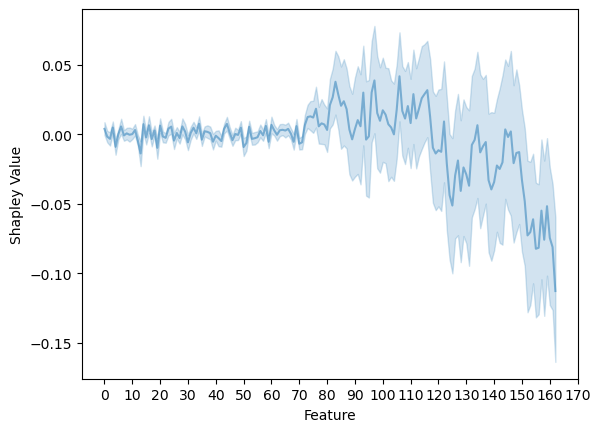

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=all_df_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax)
ax.set_xticks(list(range(180, 5)), list(range(180, 5)))
xticks = ax.set_xticks(list(range(0, 180, 10)), list(range(0, 180, 10)))

Text(0.5, 1.0, 'SHAP values from GDD model and interpretation from\nresponse functions')

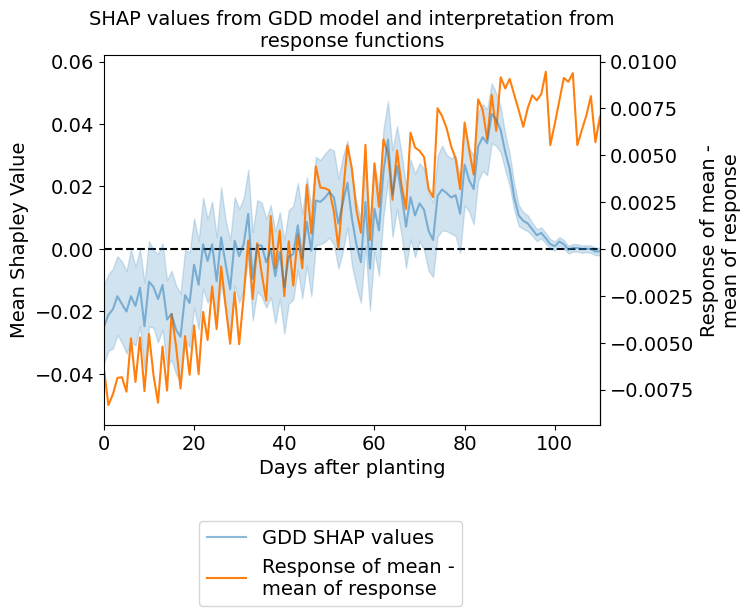

In [ ]:
w = 8
font_size = 14
fig, ax = plt.subplots()
df_transformed_GDD = feats_to_dayofseason(all_df_GDD)
#df_transformed_CCNN = feats_to_dayofseason(all_df_CCNN)
#sns.lineplot(data=df_transformed_GDD, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'GDD SHAP values', zorder = 2, legend=False)
#sns.lineplot(data=df_transformed_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'CCNN', zorder = 2)
temp_discrep = (response(temp_indexing.numpy().swapaxes(1, 2)) - response(temp_indexing.numpy().swapaxes(1, 2).mean(axis=0))).mean(axis = 0)#background_GDD(response(input_xb_GDD) - response(background_GDD)).mean(axis = 0)#np.convolve((response(input_xb_GDD) - response(background_GDD)).mean(axis = 0).squeeze(), np.ones(w), 'valid') / w
ax.plot(range(163), -(6*temp_discrep), zorder = 1, label = 'Response of mean -\nmean of response')
ax.set_xlim([0, 110])
ax.axhline(0, color = 'k', linestyle = '--', zorder = 0)
ax.set_xlabel('Days after planting', fontsize = font_size)
ax.set_ylabel('Mean Shapley Value', fontsize = font_size)
def coords_to_resps(x):
    return x/6
def resps_to_coords(y):
    return 6*y
secax_y = ax.secondary_yaxis('right', functions=(coords_to_resps, resps_to_coords))
secax_y.set_ylabel('Response of mean -\nmean of response', fontsize = font_size)
secax_y.tick_params(labelsize = font_size)
ax.tick_params(labelsize = font_size)
fig.legend(bbox_to_anchor = (0.7, -0.07), fontsize = font_size)
ax.set_title('SHAP values from GDD model and interpretation from\nresponse functions', fontsize = font_size)

#sns.lineplot(data=all_df_GDD, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'GDD')
#sns.lineplot(data=all_df_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'CCNN')
#xticks = ax.set_xticks(list(range(0, 180, 10)), list(range(0, 180, 10)))

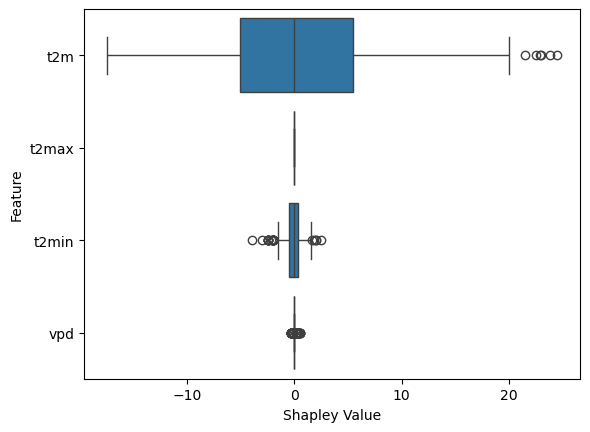

In [ ]:
ax = sns.boxplot(data=all_df_features, x='Shapley Value', y='Feature')#, orient = 'v')#, stat='density', common_norm=False, bins = 10)
ax.set_yticks([0, 1, 2, 3], ['t2m', 't2max', 't2min', 'vpd'])

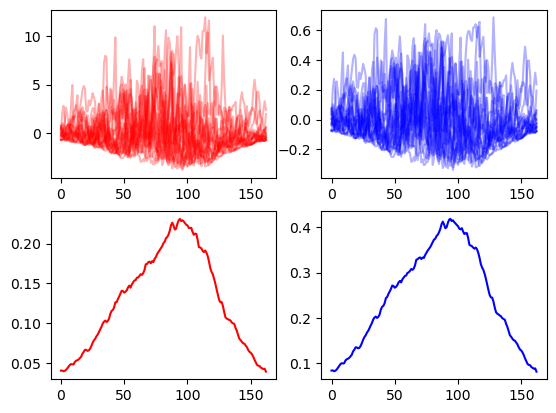

In [ ]:
fig, axs = plt.subplots(2, 2)
for ind in range(800, 820):
    axs[0, 0].plot(input_xb[ind, :, 0] - background[:, 0], color = 'red', alpha = 0.3)#input_xb_GDD.mean(axis=0)
    axs[0, 1].plot(input_xb_GDD[ind, :, 0] - background_GDD[:, 0], color = 'blue', alpha = 0.3)#background_GDD[:, 0]
axs[1, 0].plot(background[:, 0]/20, color = 'red')
axs[1, 1].plot(background_GDD[:, 0], color = 'blue')#input_xb_GDD.mean(axis=0)